# Gauge Dataset

## Goals
10/23 Meeting
- Clean data
- Get hourly average values
- Analyze with time series methods

## To Do
- Fix axes on seasonality plots
- Devise strategy to predict on hourly data

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Install for specific python version
! python3.10 -m pip install statsmodels -q

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
# Display entire dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [10]:
cd '/Users/shifraisaacs/Documents/Externship/cgi_flood_prediction_mitigation'

/Users/shifraisaacs/Documents/Externship/cgi_flood_prediction_mitigation


In [11]:
gauge = pd.read_csv('Data/raw_gauge.csv')
print(gauge.shape)
gauge.head()

(526202, 6)


,agency_cd,site_no,datetime,tz_cd,195113_00065,195113_00065_cd
0,USGS,1464000,10/1/07 01:00,EDT,2.39,A
1,USGS,1464000,10/1/07 01:15,EDT,2.39,A
2,USGS,1464000,10/1/07 01:30,EDT,2.39,A
3,USGS,1464000,10/1/07 01:45,EDT,2.39,A
4,USGS,1464000,10/1/07 02:00,EDT,2.38,A


### Unique values within each column

In [12]:
for col in gauge:
	print(f'{col}: {gauge[col].unique()}')

agency_cd: ['USGS']
site_no: [1464000]
datetime: ['10/1/07 01:00' '10/1/07 01:15' '10/1/07 01:30' ... '10/22/22 21:45'
 '10/22/22 22:00' '10/22/22 22:15']
tz_cd: ['EDT' 'EST']
195113_00065: [ 2.39  2.38  2.37 ... 10.06  9.69  9.49]
195113_00065_cd: ['A' 'P']


## Data Dictionary
- datetime: date and time of measurement
- tz_cd: Timezone; EST and EDT (for daylight savings) can be use interchangably
- 195113_00065 is water level measured in inches
- Unimportant columns to be deleted: agency_cd, cdsite_no, 195113_00065_cd, tz_cd
- We're only interested in the columns datetime and 195113_00065, both of which need to be converted

In [13]:
gauge = gauge[['datetime', '195113_00065']]
gauge.head()

,datetime,195113_00065
0,10/1/07 01:00,2.39
1,10/1/07 01:15,2.39
2,10/1/07 01:30,2.39
3,10/1/07 01:45,2.39
4,10/1/07 02:00,2.38


In [14]:
# No null values!
gauge.isnull().sum()

datetime        0
195113_00065    0
dtype: int64

### Data Cleaning and Manipulation
- datetime: separate columns into date and time
- 195113_00065: rename to water level

In [15]:
# Split datetime col into date and time
gauge[['date','time']] = gauge['datetime'].str.split(expand=True)
gauge.head()

,datetime,195113_00065,date,time
0,10/1/07 01:00,2.39,10/1/07,01:00
1,10/1/07 01:15,2.39,10/1/07,01:15
2,10/1/07 01:30,2.39,10/1/07,01:30
3,10/1/07 01:45,2.39,10/1/07,01:45
4,10/1/07 02:00,2.38,10/1/07,02:00


In [16]:
gauge.rename(columns={'195113_00065':'water_level'}, inplace=True)
gauge['water_level'].astype('float16')
gauge.head()

,datetime,water_level,date,time
0,10/1/07 01:00,2.39,10/1/07,01:00
1,10/1/07 01:15,2.39,10/1/07,01:15
2,10/1/07 01:30,2.39,10/1/07,01:30
3,10/1/07 01:45,2.39,10/1/07,01:45
4,10/1/07 02:00,2.38,10/1/07,02:00


### Group data so that each hour has an average water_level

In [17]:
# Get all times on the hour
hourly_times = gauge[gauge['time'].str[-2:] == '00'].reset_index()
hourly_times.drop(columns='water_level', inplace=True)
hourly_times.head()

,index,datetime,date,time
0,0,10/1/07 01:00,10/1/07,01:00
1,4,10/1/07 02:00,10/1/07,02:00
2,8,10/1/07 03:00,10/1/07,03:00
3,12,10/1/07 04:00,10/1/07,04:00
4,16,10/1/07 05:00,10/1/07,05:00


In [18]:
hourly_water_level = gauge.groupby(np.arange(len(gauge))//4).mean()
hourly_water_level.head()

,water_level
0,2.390
1,2.375
2,2.360
3,2.340
4,2.315


### Concat dataframes! New water level = average over the hour

In [19]:
gauge = pd.concat([hourly_times, hourly_water_level], axis=1)
gauge.drop(columns='index', inplace=True)
gauge.head()

,datetime,date,time,water_level
0,10/1/07 01:00,10/1/07,01:00,2.390
1,10/1/07 02:00,10/1/07,02:00,2.375
2,10/1/07 03:00,10/1/07,03:00,2.360
3,10/1/07 04:00,10/1/07,04:00,2.340
4,10/1/07 05:00,10/1/07,05:00,2.315


In [20]:
# Convert to datetime format
gauge['datetime'] = pd.to_datetime(gauge['datetime'], infer_datetime_format=True)
gauge['date'] = pd.to_datetime(gauge['date'], infer_datetime_format=True)
gauge['time'] = pd.to_datetime(gauge['time'], infer_datetime_format=True)
type(gauge['date'])

pandas.core.series.Series

In [21]:
# Remove null valus
gauge = gauge.dropna()
gauge.isnull().sum()

datetime       0
date           0
time           0
water_level    0
dtype: int64

In [22]:
gauge.to_csv('cleaned_gauge.csv')

## Create data subsets

In [23]:
# Since 2012
gauge_10yr = gauge[gauge['datetime'] >= pd.Timestamp(2012,1,1)]
gauge_10yr.head()

,datetime,date,time,water_level
37190,2012-01-01 00:00:00,2012-01-01,2022-10-26 00:00:00,3.3450
37191,2012-01-01 01:00:00,2012-01-01,2022-10-26 01:00:00,3.3525
37192,2012-01-01 02:00:00,2012-01-01,2022-10-26 02:00:00,3.3550
37193,2012-01-01 03:00:00,2012-01-01,2022-10-26 03:00:00,3.3500
37194,2012-01-01 04:00:00,2012-01-01,2022-10-26 04:00:00,3.3500


In [24]:
# Since 2017
gauge_5yr = gauge[gauge['datetime'] >= pd.Timestamp(2017,1,1)]
gauge_5yr.head()

,datetime,date,time,water_level
80736,2017-01-01 00:00:00,2017-01-01,2022-10-26 00:00:00,3.4950
80737,2017-01-01 01:00:00,2017-01-01,2022-10-26 01:00:00,3.4875
80738,2017-01-01 02:00:00,2017-01-01,2022-10-26 02:00:00,3.4750
80739,2017-01-01 03:00:00,2017-01-01,2022-10-26 03:00:00,3.4625
80740,2017-01-01 04:00:00,2017-01-01,2022-10-26 04:00:00,3.4600


In [25]:
# Year of 2021
gauge_1yr = gauge[gauge['datetime'] >= pd.Timestamp(2021,1,1)]
gauge_1yr = gauge_1yr[gauge_1yr['datetime'] < pd.Timestamp(2022,1,1)]
gauge_1yr.tail()

,datetime,date,time,water_level
124550,2021-12-31 19:00:00,2021-12-31,2022-10-26 19:00:00,3.3875
124551,2021-12-31 20:00:00,2021-12-31,2022-10-26 20:00:00,3.3775
124552,2021-12-31 21:00:00,2021-12-31,2022-10-26 21:00:00,3.3675
124553,2021-12-31 22:00:00,2021-12-31,2022-10-26 22:00:00,3.3600
124554,2021-12-31 23:00:00,2021-12-31,2022-10-26 23:00:00,3.3600


## Data Visualization

In [26]:
# Setup
plt.rcParams["figure.figsize"] = (20,10)
plt.figure(dpi=1000)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

<Figure size 20000x10000 with 0 Axes>

In [27]:
names = ['all time', '2012 to 2022', '2017 to 2022', 'Year 2021']
time_periods = [gauge, gauge_10yr, gauge_5yr, gauge_1yr]
period_params = [24, 168, 730] # hours in 1 day, week, month, respectively

all time


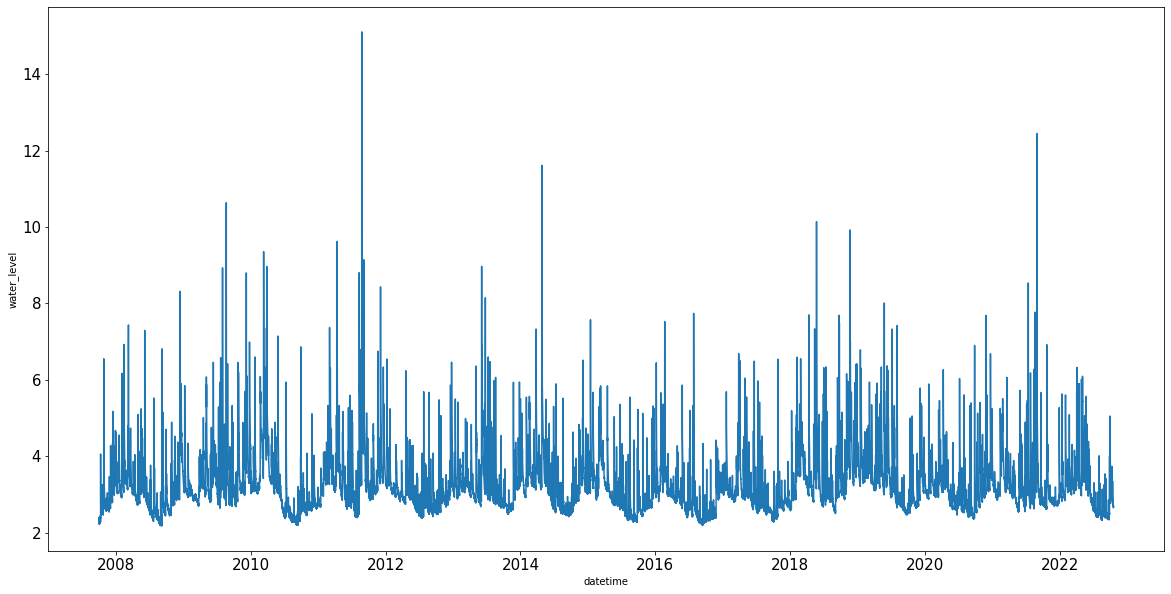

2012 to 2022


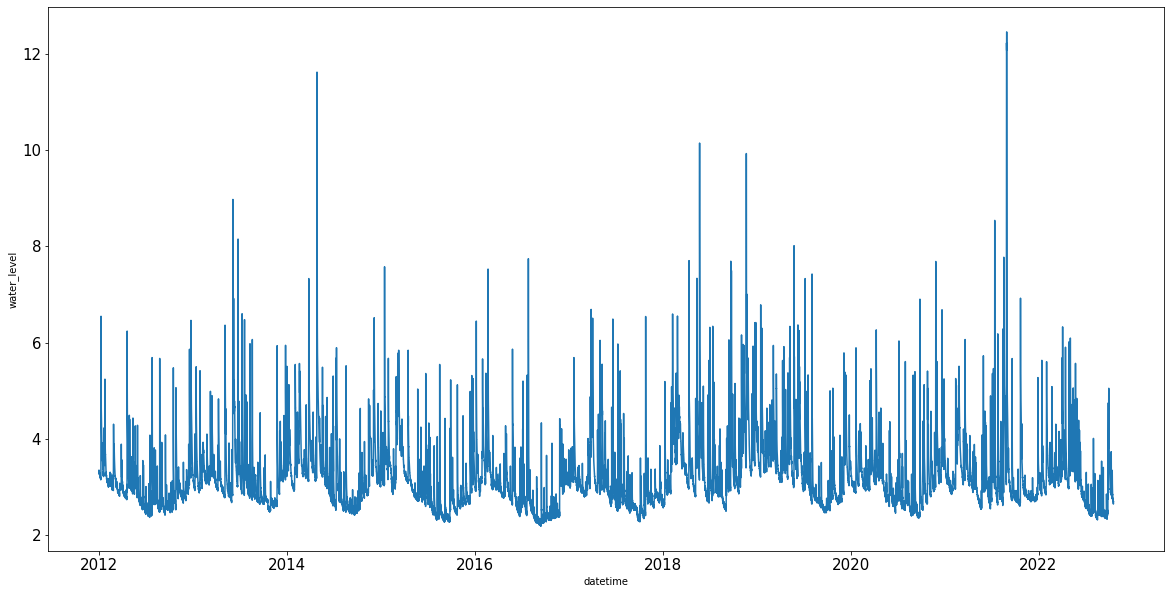

2017 to 2022


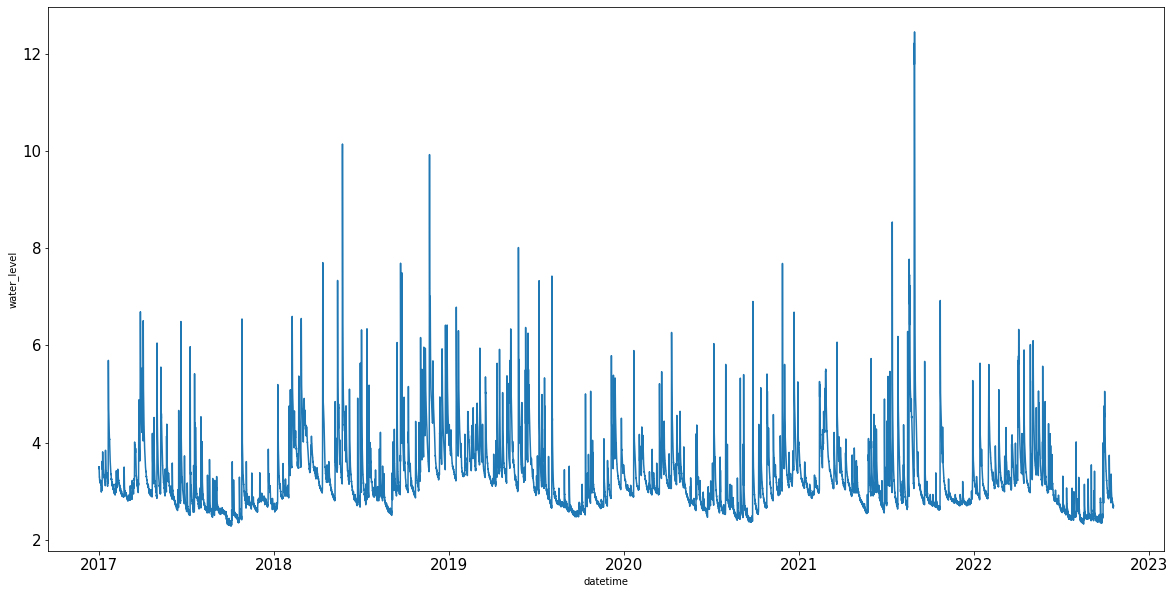

Year 2021


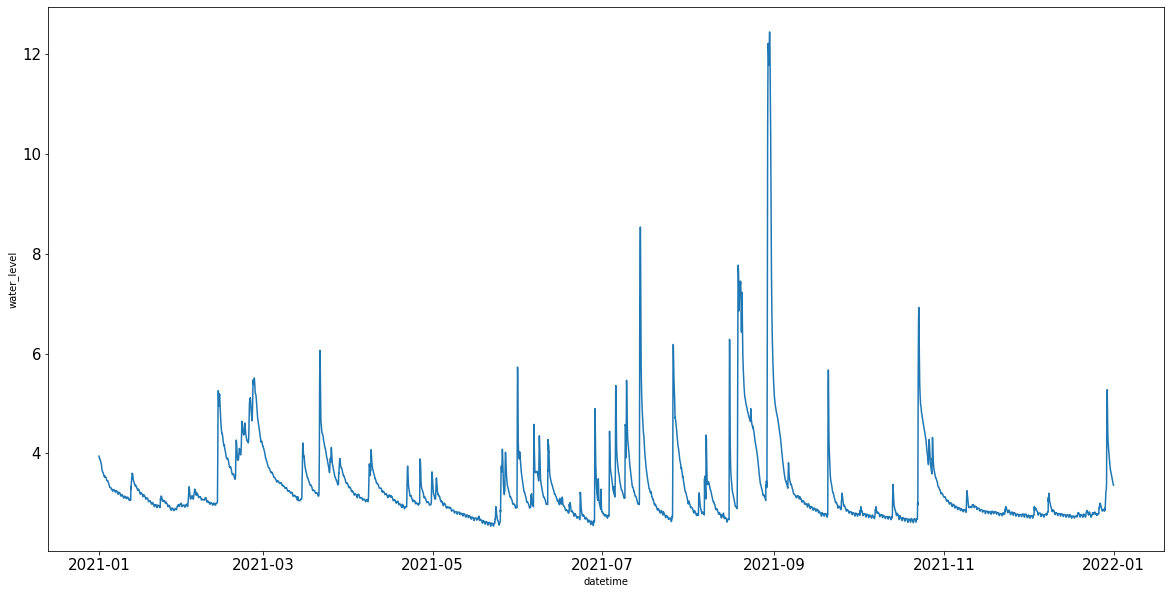

In [28]:
for name, period in zip(names,time_periods):
	print(name)
	sns.lineplot(x="datetime", y="water_level", data=period)
	plt.show()

# Time Series Modeling

### Seasonal Decomposition for all datasets

Data: all time, Period: 24 hours


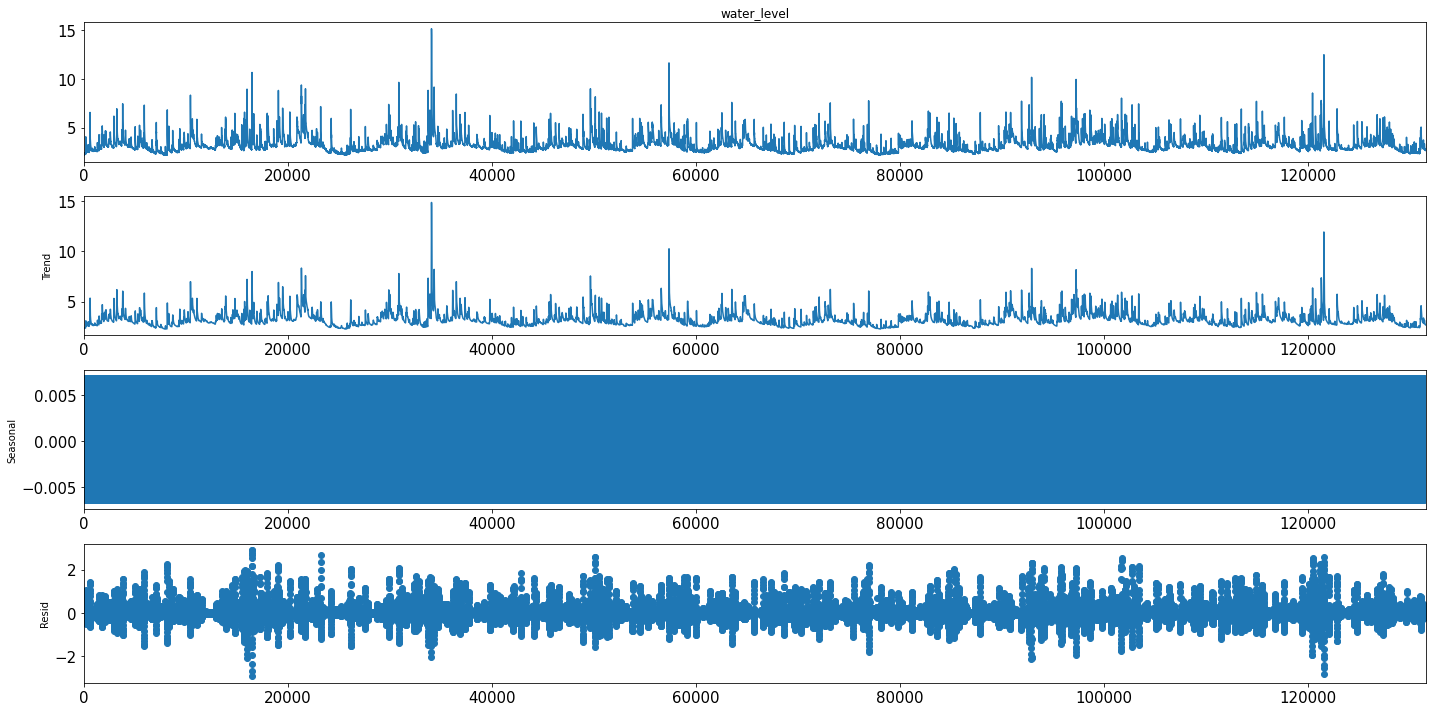

Data: all time, Period: 168 hours


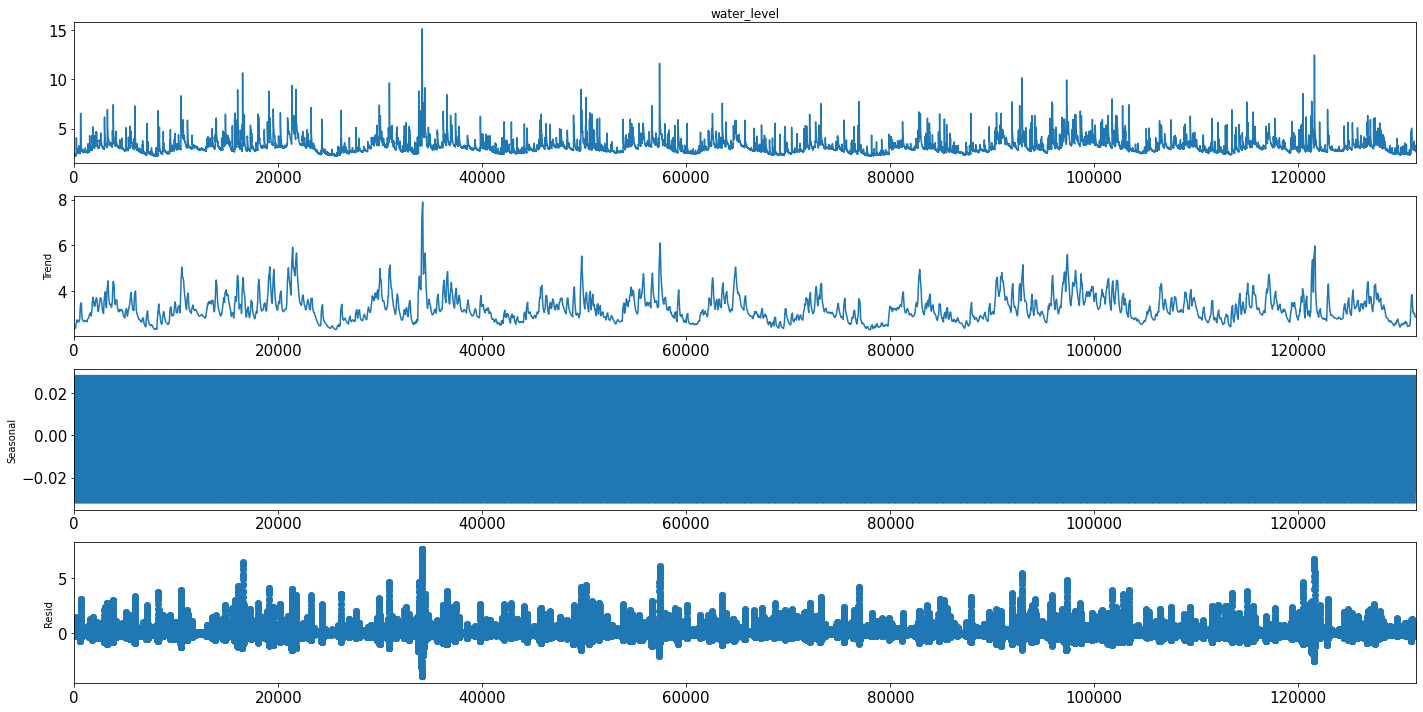

Data: all time, Period: 730 hours


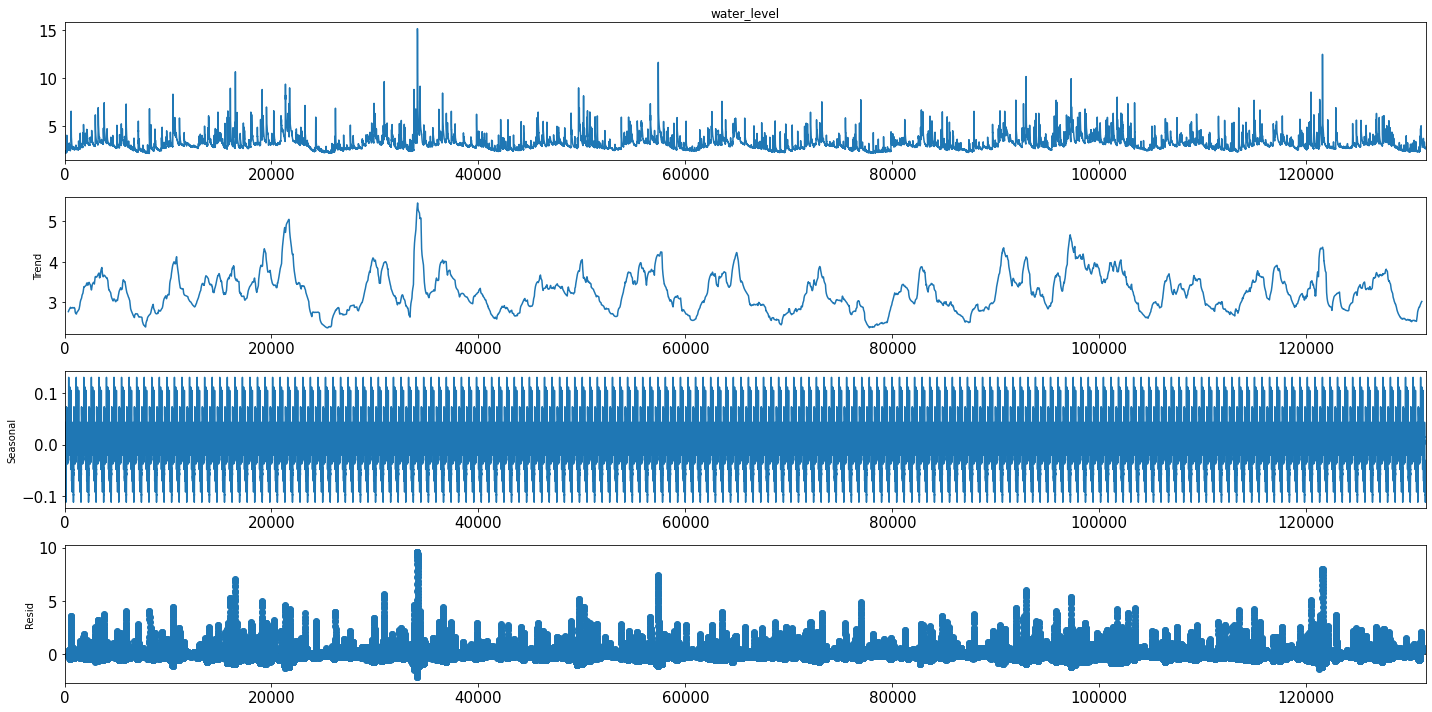

Data: 2012 to 2022, Period: 24 hours


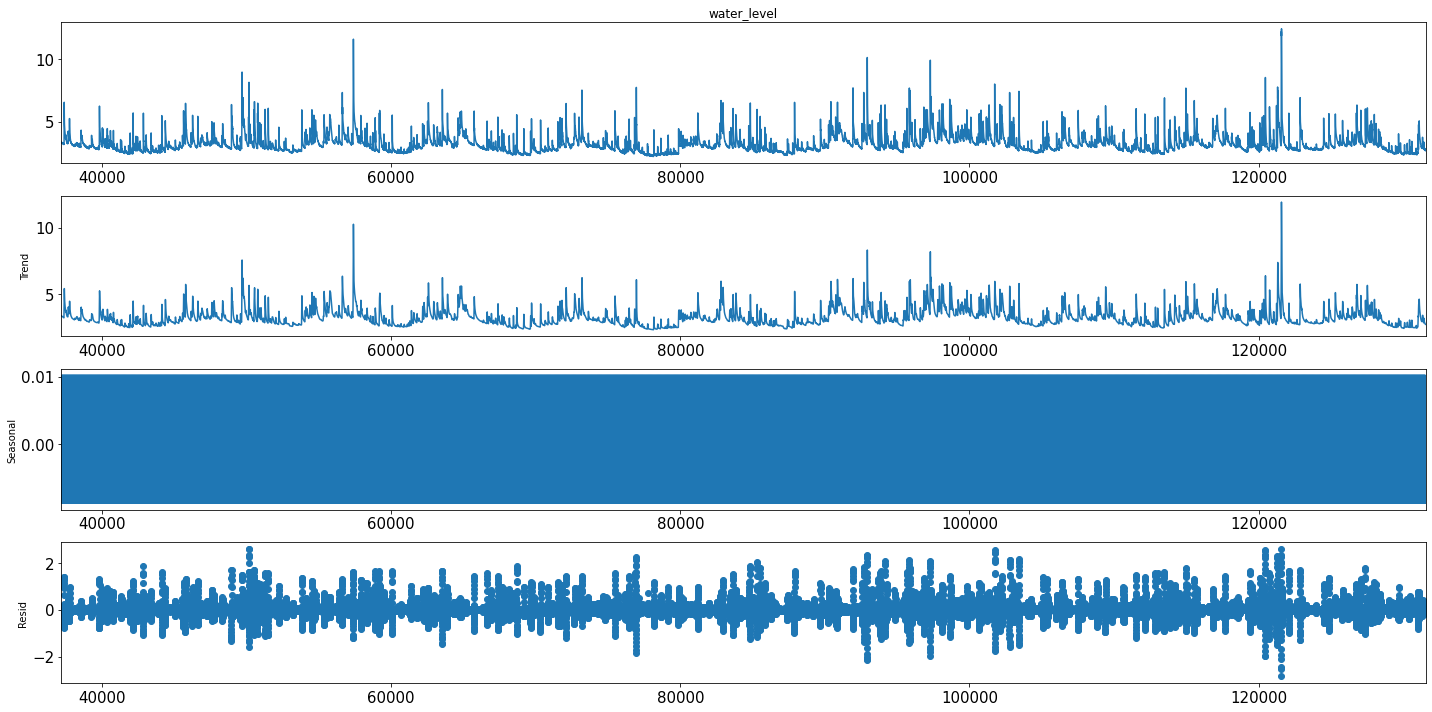

Data: 2012 to 2022, Period: 168 hours


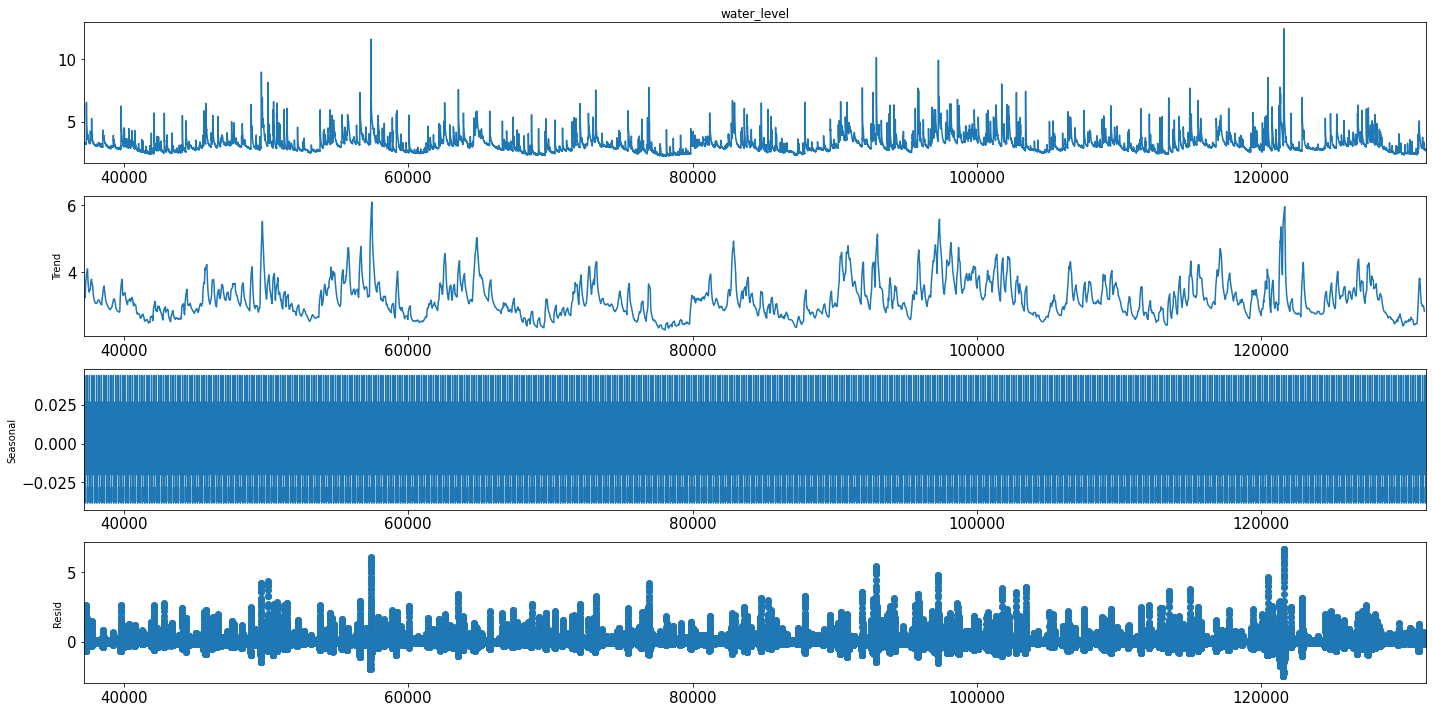

Data: 2012 to 2022, Period: 730 hours


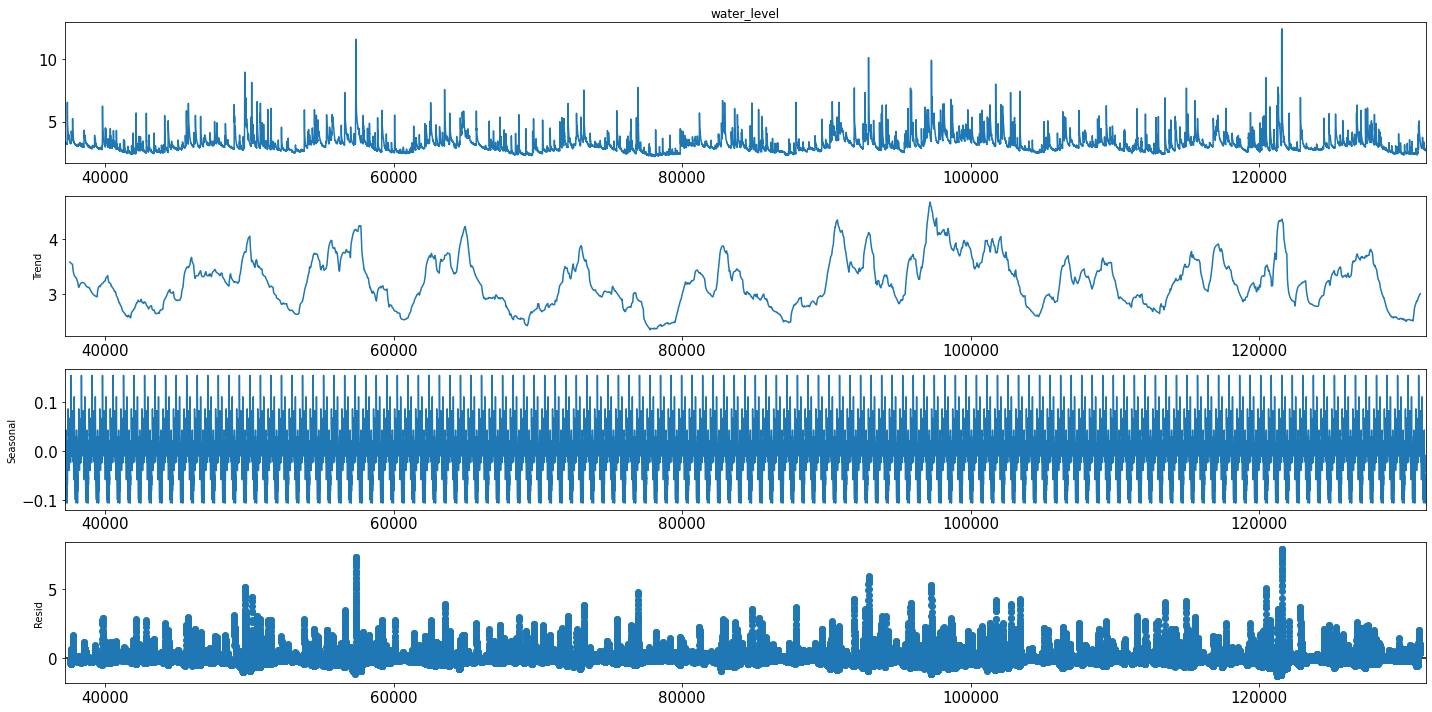

Data: 2017 to 2022, Period: 24 hours


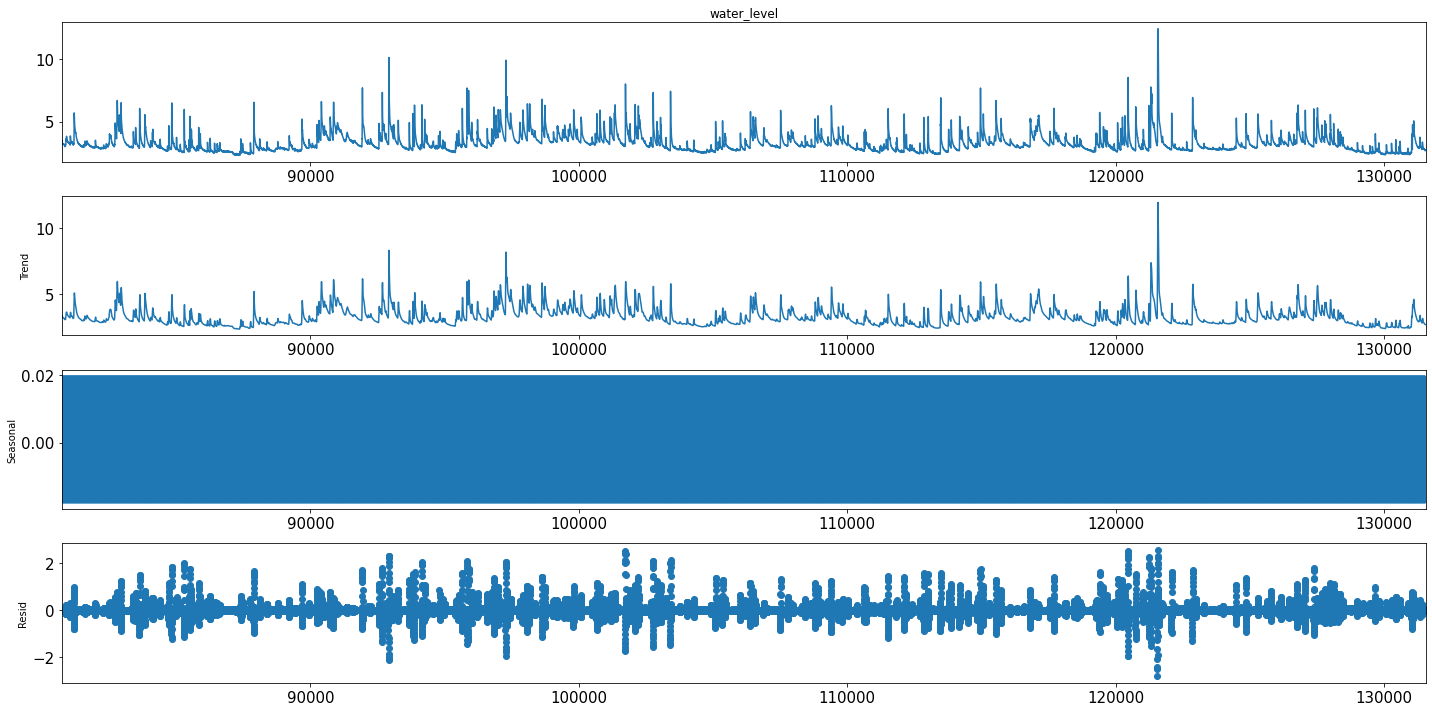

Data: 2017 to 2022, Period: 168 hours


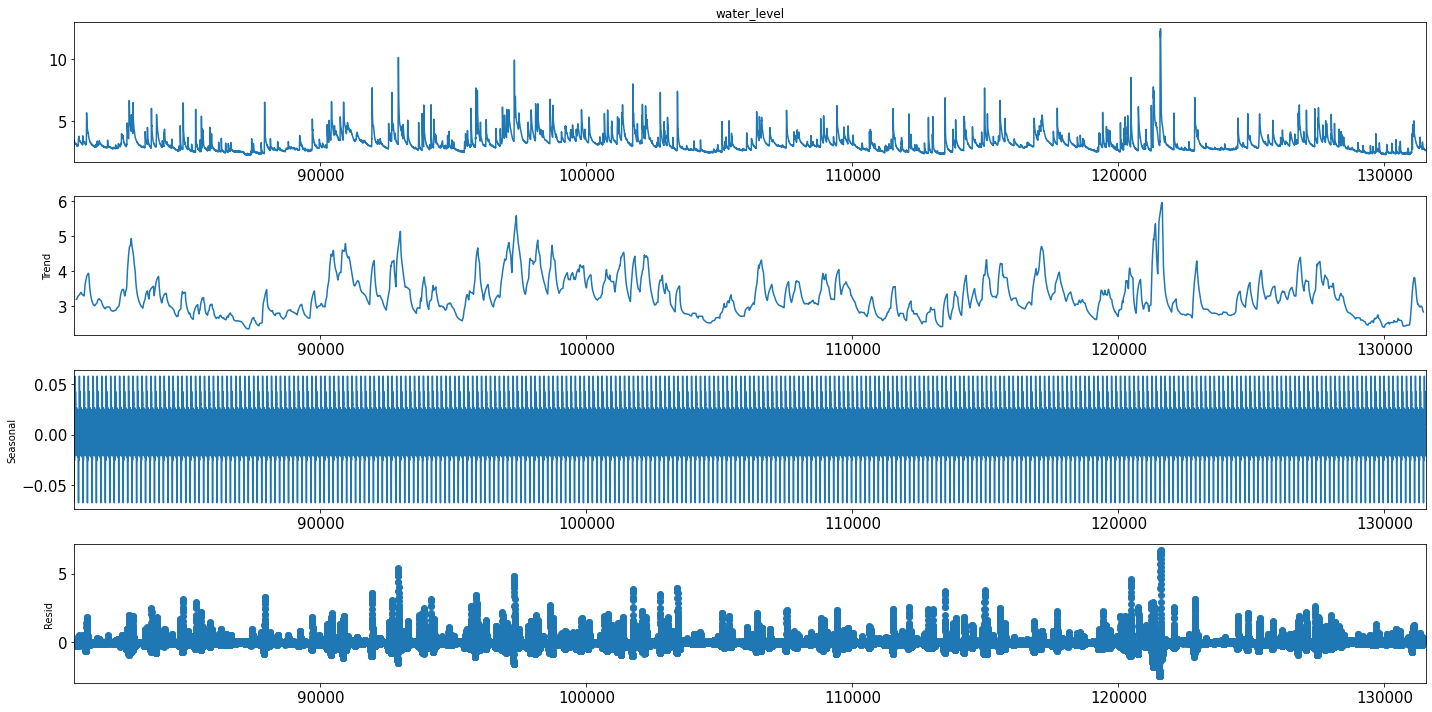

Data: 2017 to 2022, Period: 730 hours


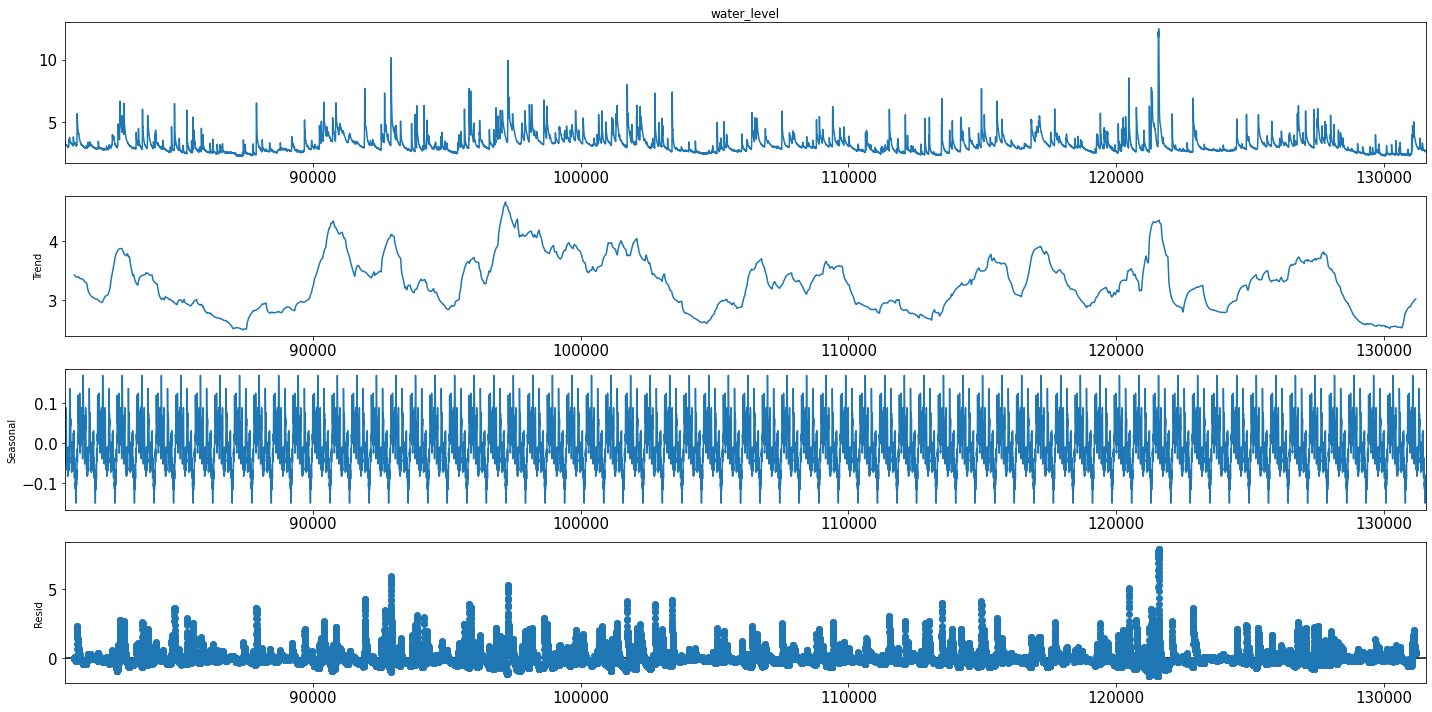

Data: Year 2021, Period: 24 hours


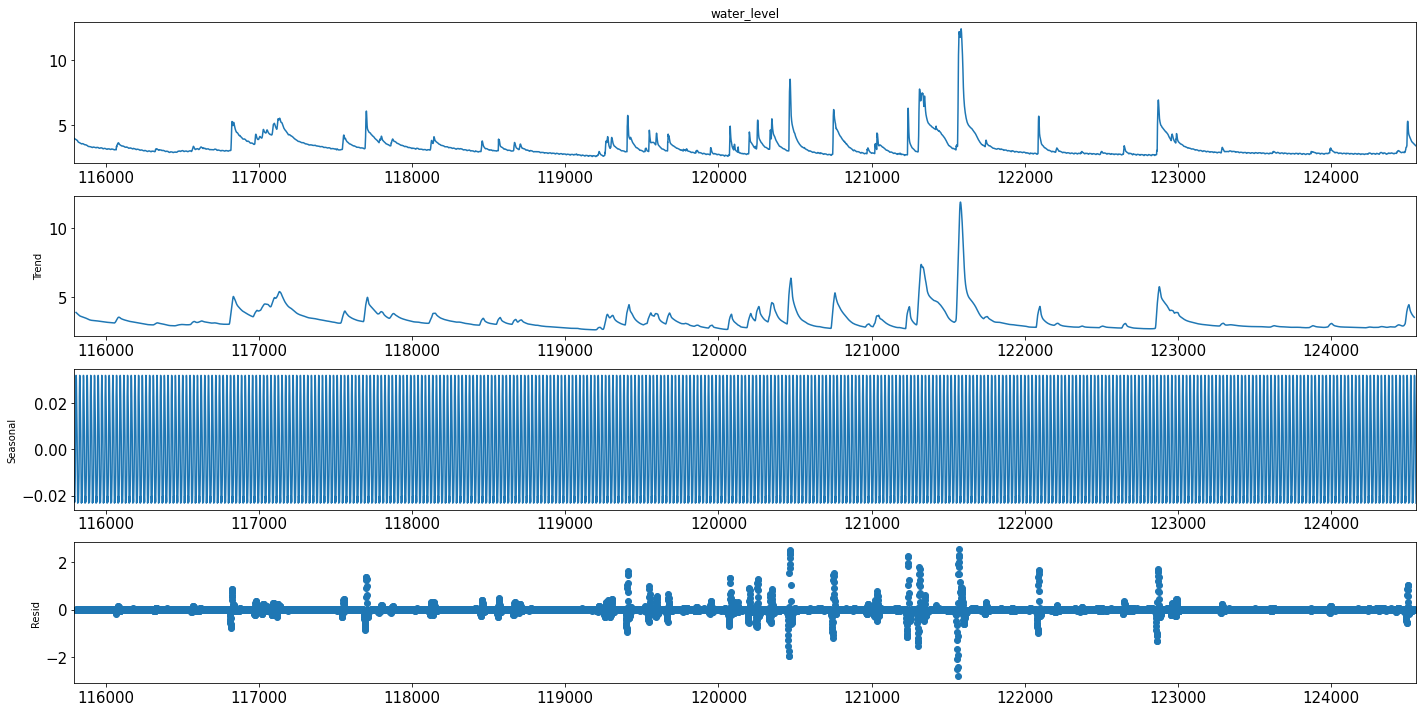

Data: Year 2021, Period: 168 hours


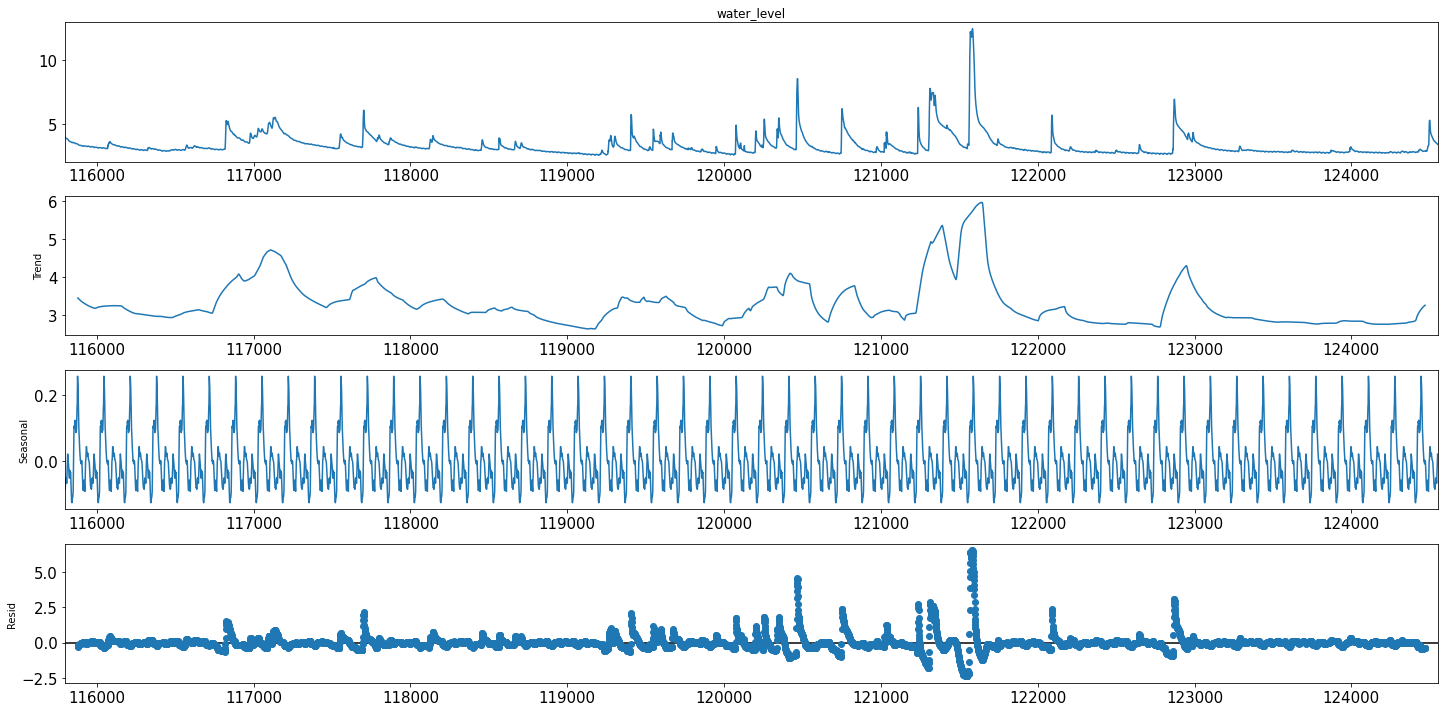

Data: Year 2021, Period: 730 hours


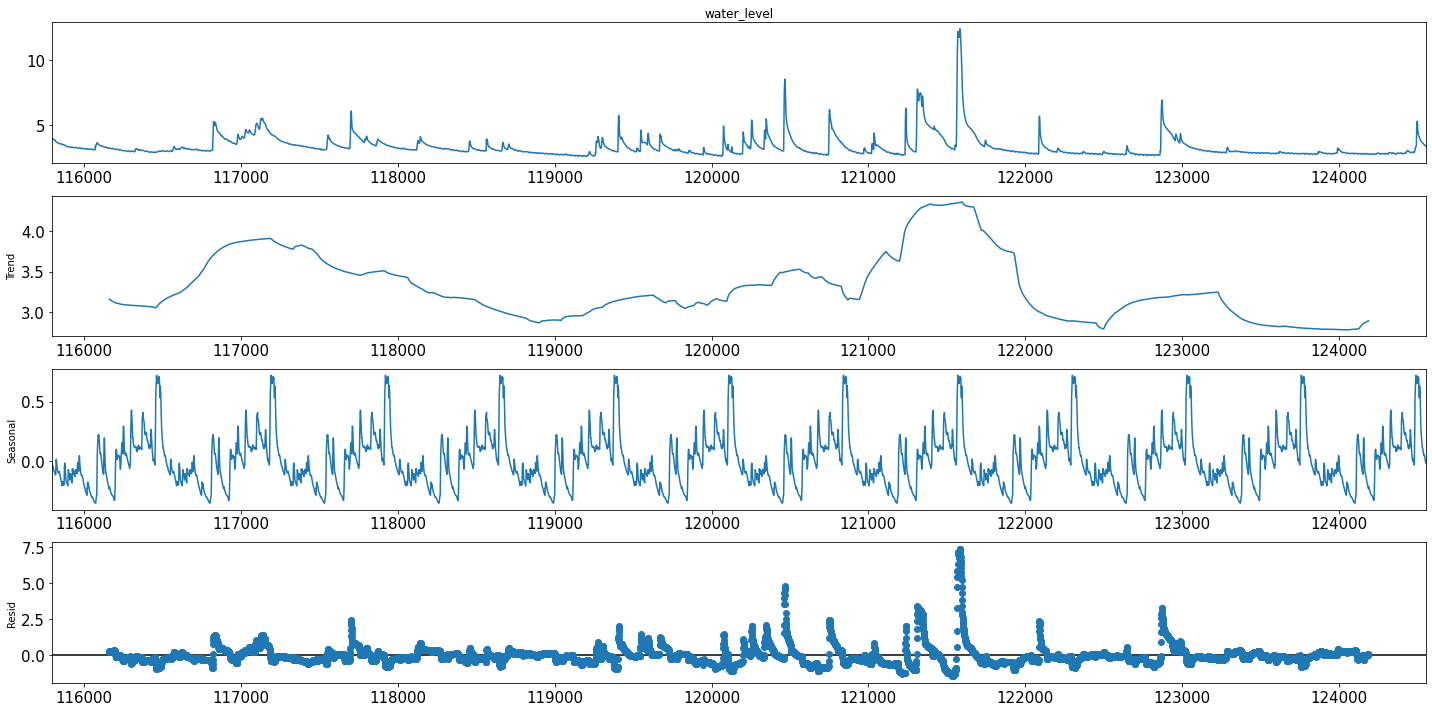

In [29]:
for name, time in zip(names, time_periods):
	for period in period_params:
		print(f'Data: {name}, Period: {period} hours')
		result = seasonal_decompose(time['water_level'], model='additive', period=period)
		result.plot()
		plt.show()